Carregando e pré-processando imagem...
Executando algoritmo de Gerchberg-Saxton...


C:\Users\humberto25043\AppData\Local\Temp\ipykernel_27608\1657774598.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.LANCZOS)


Iteração 10/50, Correlação: 0.9527
Iteração 20/50, Correlação: 0.9596
Iteração 30/50, Correlação: 0.9620
Iteração 40/50, Correlação: 0.9632
Iteração 50/50, Correlação: 0.9640
Reconstruindo imagem...


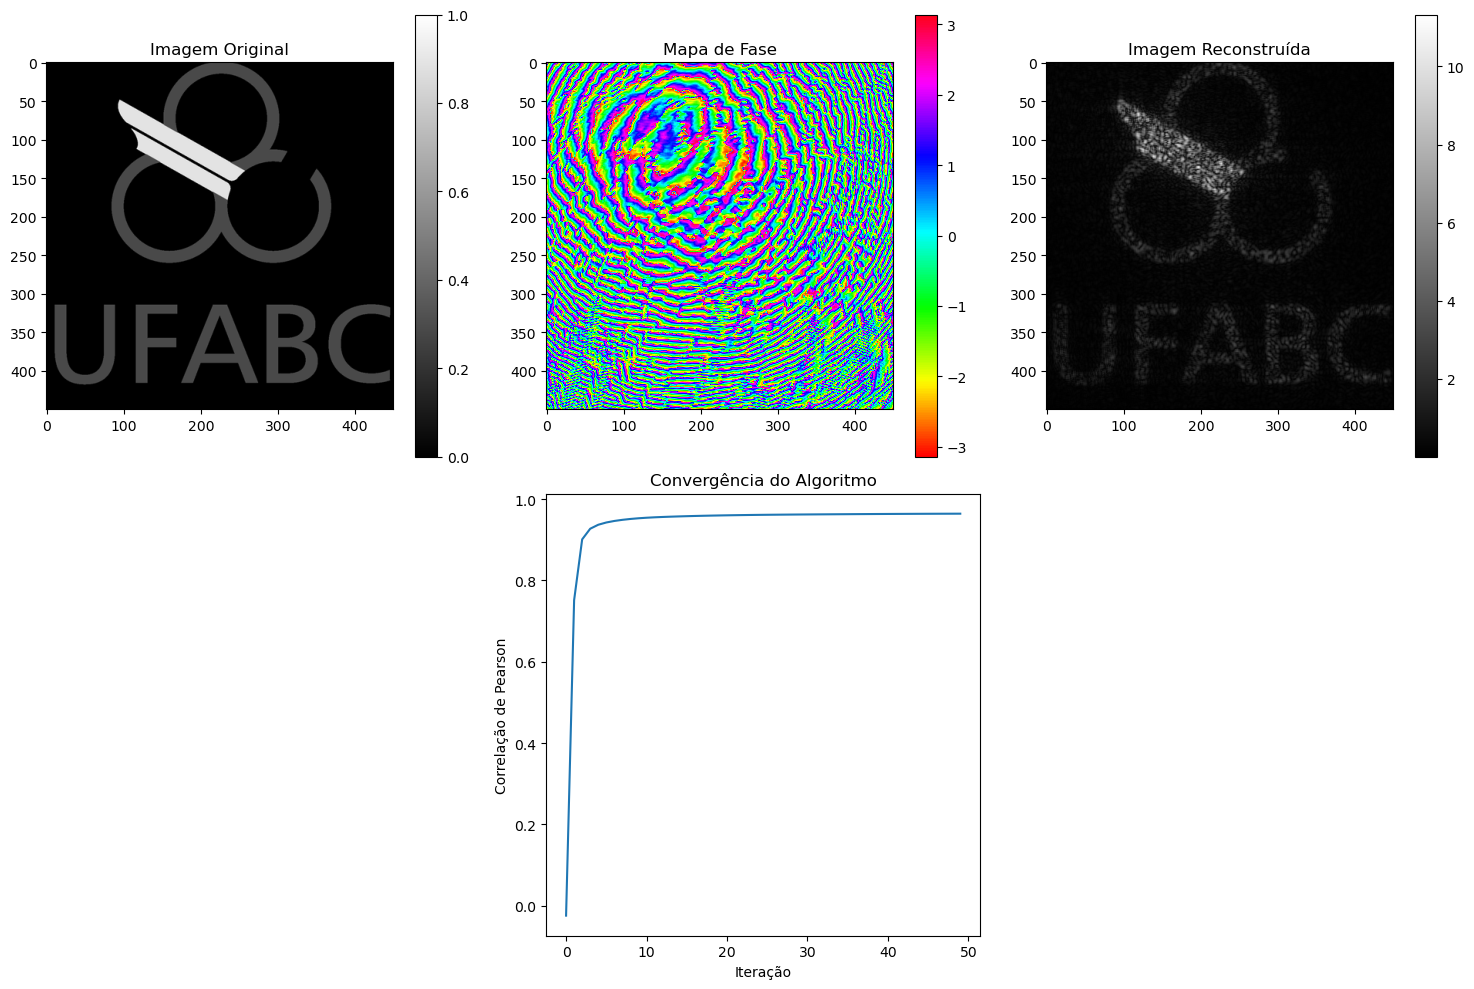

Correlação final: 0.9640
Mapa de fase salvo em 'phase_map_x_polarization.txt'
Resultados visuais salvos em 'resultados_holografia.png'


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image

def load_and_preprocess_image(image_path, target_size=(450, 450)):
    """
    Carrega e pré-processa a imagem alvo usando PIL
    """
    try:
        # Carrega a imagem
        image = Image.open(image_path).convert('L')  # Converte para escala de cinza
        
        # Redimensiona para o tamanho alvo
        image = image.resize(target_size, Image.LANCZOS)
        
        # Converte para array numpy e normaliza
        image_array = np.array(image, dtype=np.float64)
        image_array = image_array / np.max(image_array)
        
        return image_array
    
    except FileNotFoundError:
        # Se a imagem não existir, cria uma imagem de teste
        print("Imagem 'ufabc.png' não encontrada. Criando imagem de teste...")
        target_image = np.zeros((450, 450))
        # Cria um padrão simples de teste (letras UFABC)
        target_image[150:300, 100:200] = 1.0  # Barra vertical
        target_image[150:200, 200:350] = 1.0  # Barra horizontal superior
        target_image[250:300, 200:350] = 1.0  # Barra horizontal inferior
        return target_image

def apply_zero_padding(image, padding_factor=2):
    """
    Aplica zero-padding à imagem
    """
    original_size = image.shape
    padded_size = (image.shape[0] * padding_factor, image.shape[1] * padding_factor)
    padded_image = np.zeros(padded_size, dtype=complex)
    
    # Coloca a imagem original no centro
    start_row = (padded_size[0] - original_size[0]) // 2
    start_col = (padded_size[1] - original_size[1]) // 2
    padded_image[start_row:start_row+original_size[0], 
                start_col:start_col+original_size[1]] = image
    
    return padded_image, original_size

def create_low_pass_filter(shape, wavelength, dx, NA):
    """
    Cria filtro passa-baixa baseado na abertura numérica
    """
    nx, ny = shape
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')
    
    # Calcula a frequência de corte
    f_cutoff = NA / wavelength
    
    # Cria máscara circular
    freq_radius = np.sqrt(FX**2 + FY**2)
    filter_mask = (freq_radius <= f_cutoff).astype(np.float64)
    
    return filter_mask

def angular_spectrum_propagation(U, wavelength, z, dx, filter_mask=None):
    """
    Propaga o campo usando método do espectro angular
    """
    k = 2 * np.pi / wavelength
    nx, ny = U.shape
    
    # Calcula o kernel de propagação
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')
    
    # Calcula o termo dentro da raiz quadrada
    root_term = 1 - (wavelength * FX)**2 - (wavelength * FY)**2
    
    # Aplica tratamento para valores negativos (ondas evanescentes)
    root_term[root_term < 0] = 0  # Define valores negativos como zero
    
    # Kernel de propagação
    H = np.exp(1j * k * z * np.sqrt(root_term))
    
    # Aplica filtro se fornecido
    if filter_mask is not None:
        H = H * filter_mask
    
    # Propaga o campo
    U_freq = fft2(U)
    U_prop_freq = U_freq * H
    U_prop = ifft2(U_prop_freq)
    
    return U_prop

def calculate_correlation(target, reconstructed):
    """
    Calcula a correlação de Pearson entre duas imagens (valores reais)
    """
    # Garante que os arrays são reais
    target_real = np.real(target).flatten()
    reconstructed_real = np.real(reconstructed).flatten()
    
    # Calcula correlação de Pearson
    correlation = np.corrcoef(target_real, reconstructed_real)[0, 1]
    
    # Se houver NaN, retorna 0
    if np.isnan(correlation):
        return 0.0
    
    return float(correlation)

def extract_center(image, original_size):
    """
    Extrai região central da imagem (remove padding)
    """
    nx, ny = original_size
    start_row = (image.shape[0] - nx) // 2
    start_col = (image.shape[1] - ny) // 2
    return image[start_row:start_row+nx, start_col:start_col+ny]

def gerchberg_saxton_angular_spectrum(target, wavelength, z, dx, NA, num_iter=50):
    """
    Algoritmo de Gerchberg-Saxton com espectro angular
    """
    # Aplica zero-padding
    target_padded, original_size = apply_zero_padding(target)
    nx_pad, ny_pad = target_padded.shape
    
    # Cria filtro passa-baixa
    filter_mask = create_low_pass_filter((nx_pad, ny_pad), wavelength, dx, NA)
    
    # Inicializa com fase aleatória
    phase = np.random.rand(nx_pad, ny_pad) * 2 * np.pi
    U = target_padded * np.exp(1j * phase)
    
    # Lista para armazenar métricas de convergência
    correlations = []
    
    for i in range(num_iter):
        # 1. Propaga para o plano da imagem (Fresnel)
        U_image = angular_spectrum_propagation(U, wavelength, z, dx, filter_mask)
        
        # 2. Mantém a fase, atualiza amplitude com alvo
        amplitude_image = np.abs(U_image)
        phase_image = np.angle(U_image)
        
        # Calcula correlação para monitorar convergência
        target_region = extract_center(target_padded, original_size)
        recon_region = extract_center(amplitude_image, original_size)
        
        # Correlação de Pearson (garantindo valores reais)
        corr = calculate_correlation(target_region, recon_region)
        correlations.append(corr)
        
        # Atualiza campo no plano da imagem
        U_image_updated = target_padded * np.exp(1j * phase_image)
        
        # 3. Propaga de volta para o plano do holograma
        U = angular_spectrum_propagation(U_image_updated, wavelength, -z, dx, filter_mask)
        
        # 4. Mantém a fase, atualiza amplitude com incidente (unitária)
        phase_hologram = np.angle(U)
        U = np.exp(1j * phase_hologram)  # Amplitude unitária
        
        if (i + 1) % 10 == 0:
            print(f"Iteração {i+1}/{num_iter}, Correlação: {corr:.4f}")
    
    # Extrai a fase final (apenas região central sem padding)
    phase_final = extract_center(np.angle(U), original_size)
    
    return phase_final, correlations

def reconstruct_image(phase_map, wavelength, z, dx, NA):
    """
    Reconstrói a imagem a partir do mapa de fase
    """
    # Aplica zero-padding ao mapa de fase
    phase_padded, original_size = apply_zero_padding(np.exp(1j * phase_map))
    
    # Cria filtro
    filter_mask = create_low_pass_filter(phase_padded.shape, wavelength, dx, NA)
    
    # Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(phase_padded, wavelength, z, dx, filter_mask)
    
    # Extrai região central
    reconstructed = extract_center(np.abs(reconstructed), original_size)
    
    return np.real(reconstructed)  # Garante valor real

# Parâmetros do sistema (baseados no artigo)
wavelength = 1064e-9  # 1064 nm
z = 460e-6         # 380 μm
dx = 520e-9         # pixel pitch
NA = 0.65            # abertura numérica
num_iter = 50       # número de iterações

# Carrega e pré-processa a imagem
print("Carregando e pré-processando imagem...")
target_image = load_and_preprocess_image('ufabc.png', target_size=(450, 450))

# Executa algoritmo de Gerchberg-Saxton
print("Executando algoritmo de Gerchberg-Saxton...")
phase_map, correlations = gerchberg_saxton_angular_spectrum(
    target_image, wavelength, z, dx, NA, num_iter
)

# Reconstrói imagem para verificação
print("Reconstruindo imagem...")
reconstructed_image = reconstruct_image(phase_map, wavelength, z, dx, NA)

# Visualização dos resultados
plt.figure(figsize=(15, 10))

# Imagem original
plt.subplot(2, 3, 1)
plt.imshow(target_image, cmap='gray')
plt.title('Imagem Original')
plt.colorbar()

# Mapa de fase
plt.subplot(2, 3, 2)
plt.imshow(phase_map, cmap='hsv')
plt.title('Mapa de Fase')
plt.colorbar()

# Imagem reconstruída
plt.subplot(2, 3, 3)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Imagem Reconstruída')
plt.colorbar()

# Correlação vs iteração
plt.subplot(2, 3, 5)
plt.plot(correlations)
plt.xlabel('Iteração')
plt.ylabel('Correlação de Pearson')
plt.title('Convergência do Algoritmo')




plt.tight_layout()
plt.savefig('resultados_holografia.png', dpi=300)
plt.show()

# Salva resultados
np.savetxt('phase_map_x_polarization.txt', phase_map)
np.savetxt('correlations.txt', correlations)

print(f"Correlação final: {correlations[-1]:.4f}")
print("Mapa de fase salvo em 'phase_map_x_polarization.txt'")
print("Resultados visuais salvos em 'resultados_holografia.png'")